In [16]:
# API OpenWeatherMap
import os
import requests
import csv
from dotenv import load_dotenv

dotenv_path = 'C:\\ETL\\API_KEY.env'
load_dotenv(dotenv_path)
openweather_api = os.getenv('OPENWEATHER_API')

def get_open_weather():
    cities = ['Moscow', 'Tyumen', 'Vladivostok']
    weather_data = []

    for city in cities:
        url = f"http://api.openweathermap.org/data/2.5/forecast?q={city}&appid={openweather_api}"
        response = requests.get(url)
        data = response.json()

        if response.status_code == 200:
            city_name = data['city']['name']
            for forecast in data['list']:
                if forecast['dt_txt'].startswith('2024-11'):
                    temperature = round(float(forecast['main']['temp']) - 273.15, 2)
                    weather_data.append({
                        'city': city_name,
                        'Date': forecast['dt_txt'],
                        'temperature': temperature,
                        'Weather': forecast['weather'][0]['description']
                    })
            if not weather_data:
                print(f"No weather data available for {city} in May 2024")
        else:
            print(f"Failed to retrieve weather data for {city}")

    return weather_data

def save_data_to_csv(weather_data):
    with open('API_OpenWeatherMap_2024.csv', mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['City', 'Date', 'Temperature', 'Weather'])
        for data in weather_data:
            writer.writerow([data['city'], data['Date'], data['temperature'], data['Weather']])

weather_data = get_open_weather()
save_data_to_csv(weather_data)

ReadTimeout: HTTPConnectionPool(host='api.openweathermap.org', port=80): Read timed out. (read timeout=None)

### DataFrame HDFS

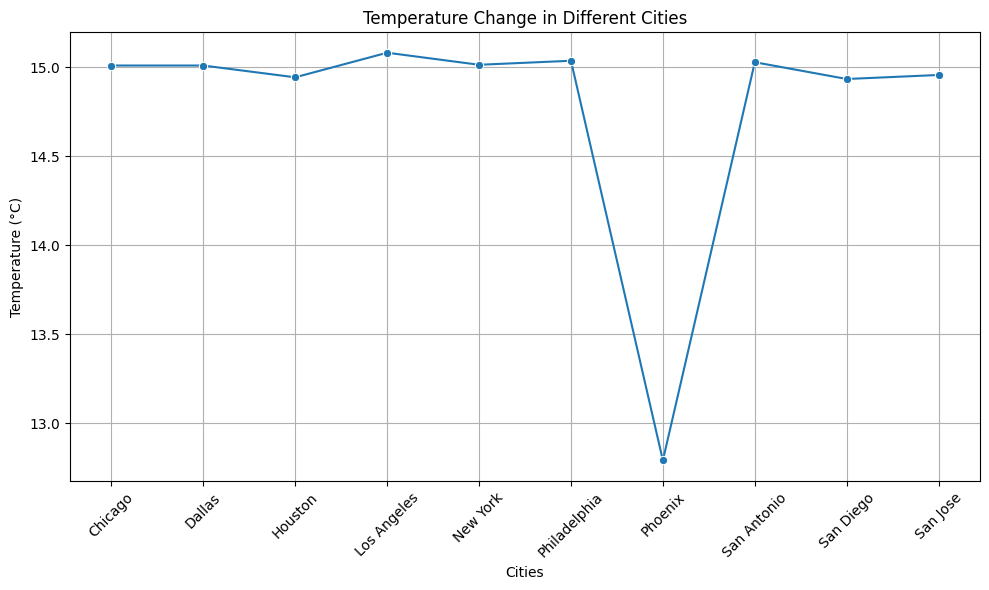

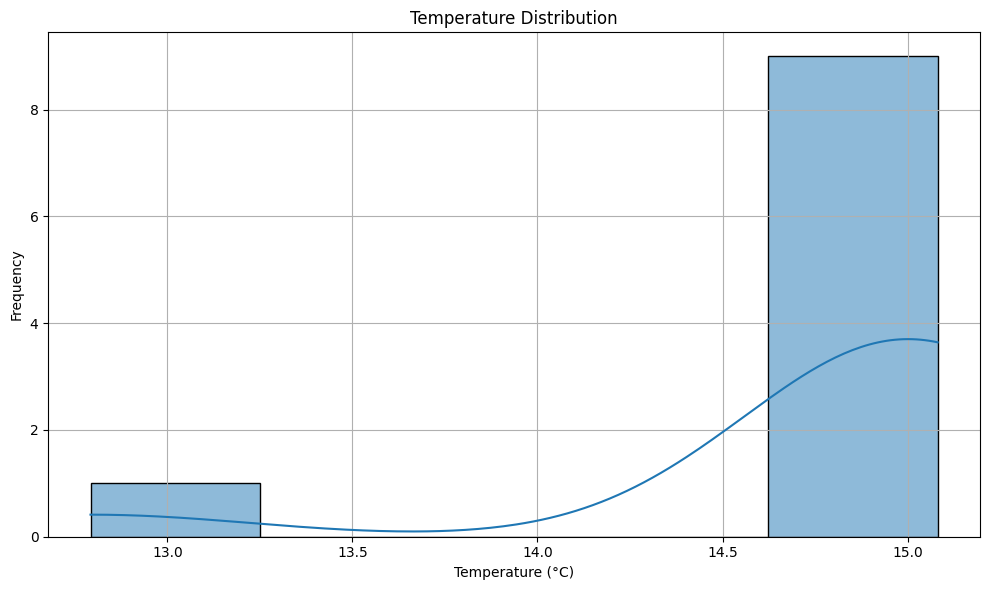

In [11]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def load_weather_data(file_path):
    df = pd.read_csv(file_path)
    return df


def extract_temperature_data(weather_data):
    temperature_data = []
    for city, data in weather_data.groupby('Location'):
        temperature = data['Temperature_C'].mean()
        temperature_data.append((city, temperature))
    return temperature_data


def plot_temperature_change(df):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x='City', y='Temperature', marker='o')
    plt.title('Temperature Change in Different Cities')
    plt.xlabel('Cities')
    plt.ylabel('Temperature (°C)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('temp_change.png')
    plt.show()


def plot_temperature_distribution(df):
    plt.figure(figsize=(10, 6))
    sns.histplot(df['Temperature'], bins=5, kde=True)
    plt.title('Temperature Distribution')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('temp_distribution.png')
    plt.show()


data_path = Path("kaggle_wqather.csv")
weather_data = load_weather_data(data_path)
temperature_data = extract_temperature_data(weather_data)
df = pd.DataFrame(temperature_data, columns=['City', 'Temperature'])

plot_temperature_change(df)
plot_temperature_distribution(df)


In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
from hdfs import InsecureClient

client = InsecureClient('http://localhost:50070')

with client.write('temp_change.png', encoding='utf-8') as writer:
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x='City', y='Temperature', marker='o')
    plt.title('Temperature Change in Different Cities')
    plt.xlabel('Cities')
    plt.ylabel('Temperature (°C)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(writer)

with client.write('temp_distribution.png', encoding='utf-8') as writer:
    plt.figure(figsize=(8, 6))
    sns.histplot(df['Temperature'], bins=10, kde=True)
    plt.title('Temperature Distribution')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(writer)

client.download('temp_change.png', 'temp_change_hdfs.png', overwrite=True)
client.download('temp_distribution.png', 'temp_distribution_hdfs.png', overwrite=True)